# IR experimental code

In [1]:
import math
import os
from typing import List, Tuple

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from theia.utils import display, read_positions

In [2]:
def approxContour(contour, options):
    """
    fit contour to a simpler shape
    accuracy is based on EPSILON_MULTIPLY
    """
    epsilon = options['epsilon'] * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return approx

In [3]:
def calc_distance(p1, p2):
    """ return the distance between two points """
    return math.sqrt(((p2[0] - p1[0])**2) + ((p2[1] - p1[1])**2))


def get_contour_lengths(approx: List[List[List[int]]]) -> List[int]:
    """ 
    extract lengths from the co-ordinates 
    """
    # unnest and arrange into each corner co-ords
    # this could be done programmatically but not really worth it
    verticies = [
            [approx[0][0], approx[1][0]],
            [approx[1][0], approx[2][0]],
            [approx[2][0], approx[3][0]],
            [approx[3][0], approx[0][0]]
        ]
    lengths = list(map(lambda x: calc_distance(x[0], x[1]), verticies))
    return sorted(lengths)


def is_square(lengths, options) -> bool:
    """ check if the longest side is close in length to the shortest side """
    a = ((lengths[3] - lengths[0]) / lengths[3]) < options["square_ar"]
    b = ((lengths[3] - lengths[1]) / lengths[3]) < options["square_ar"]
    c = ((lengths[3] - lengths[1]) / lengths[3]) < options["square_ar"]
    return a & b & c

In [32]:
def filterContours(contours, options):
    """ 
    return only the contours that are squares
    """
    squareIndexes = []

    # filter contours
    for i, contour in enumerate(contours):  # for each of the found contours
        if cv2.contourArea(contour) > options["min_area"]:
            approx = approxContour(contour, options)
            if len(approx) in options["sides"]:
                area = cv2.contourArea(approx)
                hull = cv2.convexHull(approx)
                hull_area = cv2.contourArea(hull)
                solidity = float(area)/hull_area
                if solidity > options["min_solidity"]:
                    squareIndexes.append(i)
                #if is_square(get_contour_lengths(approx), options):
    
    return squareIndexes

In [5]:
def target_centre(contour: list) -> Tuple[int, int]:
    """ 
    given the square corners, return the centre of the square 
    """
    x = sum([item[0] for item in contour])/4
    y = sum([item[1] for item in contour])/4
    return int(x), int(y)

In [27]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def find_targets(image: np.ndarray, options) -> List[List[Tuple[int,int]]]:
    """ 
    return the centre position within the image
    """
    imgGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #cl1 = clahe.apply(imgGray)
    imgBlurred = cv2.GaussianBlur(imgGray, (options["ksize"], options["ksize"]), options["sigma"])
    img_thresh = cv2.adaptiveThreshold(
        imgBlurred,
        255,
        cv2.ADAPTIVE_THRESH_MEAN_C, 
        cv2.THRESH_BINARY,
        options["block_size"],
        options["c"]
    )

    #img_morph = cv2.morphologyEx(img_thresh, cv2.MORPH_OPEN, options["kernel"])
    
    if options["debug"]: 
        display(img_thresh)

    contours, hierarchy = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    squareIndexes = filterContours(contours, options)
    
    if options["debug"]:
        imgCopy = image
        # for cont in contours:
        #     cv2.drawContours(imgCopy, cont, -1, (0, 255, 0), 3)
        # display(imgCopy)
        img2 = image
        for index in squareIndexes:
            cv2.drawContours(img2, contours[index], -1, (0, 255, 0), 3)
        display(img2)

    # this for loop is mainly to check if there are multiple squares in the same image
    # otherwise there would not be a loop
    
    results = []
    for index in squareIndexes:
        target_contour = approxContour(contours[index], options)

        reshaped = target_contour.reshape(4,2)

        centre = target_centre(reshaped)

        results.append(
            centre
        )


    if len(results) == 0:
        pass

    return results

# sim_dataset testing

In [7]:
def centre_check(predicted, actual, tol=20) -> bool:
    """ True if the centre is as expected else False """
    x = math.isclose(predicted[0], actual[0], abs_tol=tol)
    y = math.isclose(predicted[1], actual[1], abs_tol=tol)
    return x & y

In [8]:
ref = read_positions("./dataset/target_positions")

In [25]:
image_number = 50
files = [f for f in os.listdir('./dataset/sim_dataset/')]
image = cv2.imread('./dataset/sim_dataset/' + files[image_number])
print(files[image_number])

options = {
    "block_size": 399,
    "c": -39,
    "ksize": 39,
    "sigma": 0,
    "epsilon": 0.1,
    "square_ar": 0.2,
    "min_area": 10000,
    "sides":[4],
    "debug":True,
    "kernel": np.ones((30,30),np.uint8)
}

predicted = find_targets(image, options)
print(predicted)
actual = ref[files[image_number]]
print(centre_check(predicted[0], actual))
print(len(predicted) == 1)

IMG_160729_071816_0092_RGB.JPG
[(977, 635)]
False
True


In [30]:
results = []
false_positives = []

for file in files:
    image = cv2.imread('./dataset/sim_dataset/' + file)
    result = find_targets(image, options, debug=False)
    try:
        result[0]
        for r in result:
            actual = ref[file]
            if centre_check(r, actual):
                results.append(1)
            else:
                results.append(0)
                false_positives.append(1)

    except:
        #result = find_targets(image, options, debug=True)
        results.append(0)

print(f"accuracy: {round(sum(results)/len(files) * 100, 2)} %")
print(f"false positives {round(sum(false_positives)/len(results) * 100, 2)} %")
print(f"no. images: {len(files)}")

accuracy: 89.02 %
false positives 1.15 %
no. images: 173


# Understanding parameter effects

In [ ]:
results = []
image = cv2.imread('./dataset/sim_dataset/' + files[image_number])

for block_size in range(29, 249, 20):
    print(block_size)
    for c in range(-100, 20, 20):
        for ksize in range(1, 9, 2):
            for sigma in [0]: #range(0, 10, 2):
                options = {
                    "block_size": block_size,
                    "c": c,
                    "ksize": ksize,
                    "sigma": sigma
                }
                result = find_targets(image, options, debug=False)
                try:
                    result[0]
                    if result[0][0] > 1080 and result[0][0] < 1100:
                        ans = 1
                    else:
                        ans = 0
                except:
                    ans = 0
                
                results.append((block_size, c, ksize, sigma, ans))

In [ ]:
df = pd.DataFrame(results)

,0,1,2,3,4
0,29,-100,1,0,0
1,29,-100,3,0,0
2,29,-100,5,0,0
3,29,-100,7,0,0
4,29,-80,1,0,0
...,...,...,...,...,...
331,289,-20,7,0,0
332,289,0,1,0,0
333,289,0,3,0,0
334,289,0,5,0,0


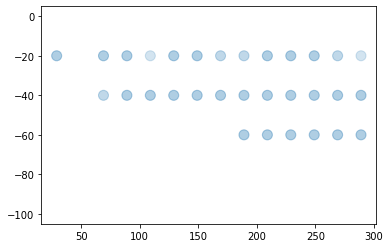

In [ ]:
plt.scatter(df[0], df[1], s=df[4]*100, alpha=0.1)

In [ ]:
df = df[df[4] == 1]

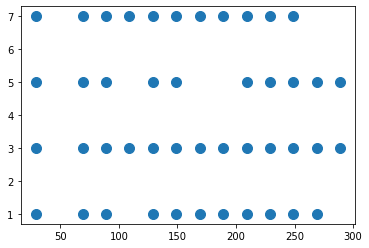

In [ ]:
df2 = df[df[1] == -20]
plt.scatter(df2[0], df2[2], s=100, alpha=1)

# Testing main IR functions

In [1]:
from theia import main
from theia import spec
import cv2
import os
from importlib import reload
reload(main)

loc = spec.LocationInfo()
image_number = 50
files = [f for f in os.listdir('./dataset/sim_dataset/')]
image = cv2.imread('./dataset/sim_dataset/' + files[image_number])
print(files[image_number])
base_dir = os.getcwd()

IMG_160729_071816_0092_RGB.JPG


In [2]:
ir = main.ImageRecognition(base_dir)
ir.image_recognition(image, loc)

2022-01-26 14:54:42,172, [INFO], main , processing image
2022-01-26 14:54:42,492, [INFO], main , ImageRecognitionResult(image_name='c:\\Users\\olive\\Documents\\GitHub\\uas-theia\\runtime\\26012022_14-54-42.240916.jpg', centre=(2310, 3193), position=(0.0, 0.0))


# Experimenting with perspective

In [18]:
ref = read_positions("./dataset/target_positions_transformed")

result = 0
files = [f for f in os.listdir('./dataset/transform_dataset/')]
for image_number in [99]: #range(len(files)):
    image = cv2.imread('./dataset/transform_dataset/' + files[image_number])
    print(files[image_number])

    options = {
        "block_size": 249,
        "c": -39,
        "ksize": 49,
        "sigma": 0,
        "epsilon": 0.02,
        "square_ar": 0.4,
        "min_area": 3000,
    }

    predicted = find_targets(image, options, debug=True)
    if len(predicted) >= 0:
        result+=1
    print(predicted)

print(result/len(files))
print(centre_check(predicted[0], (1316, 2532)))

900-900.jpg
[(1318, 2534), (3707, 288)]
0.01
True


In [33]:
options = {
    "block_size": 249,
    "c": -39,
    "ksize": 49,
    "sigma": 0,
    "epsilon": 0.02,
    "square_ar": 0.4,
    "min_area": 3000,
}
ref = read_positions("./dataset/target_positions_transformed", offset=0)
files = [f for f in os.listdir('./dataset/transform_dataset/')]
results = []
false_positives = []

for file in files:
    image = cv2.imread('./dataset/transform_dataset/' + file)
    result = find_targets(image, options, debug=False)
    try:
        result[0]
        for r in result:
            actual = ref[file]

            if centre_check(r, actual):
                results.append(1)
            else:
                results.append(0)
                false_positives.append(1)

    except Exception as e:
        results.append(0)

print(f"accuracy: {round(sum(results)/len(files) * 100, 2)} %")
print(f"false positives {round(sum(false_positives)/len(results) * 100, 2)} %")
print(f"no. images: {len(files)}")

accuracy: 80.35 %
false positives 13.55 %
no. images: 1557


# Localisation testing

In [1]:
from theia import position_estimation
from theia.spec import LocationInfo
from theia.image_segmentation import find_targets
from theia.utils import display
import cv2
import os
import math
import geopy.distance
from datetime import datetime
import numpy as np


target_location = (52.7809190, -0.7072140)
directory = r"C:\Users\pm\Downloads\images 2\squares"
files = [f for f in os.listdir(directory)]


image = cv2.imread(directory + "//" + files[0])

src = image
width  = src.shape[1]
height = src.shape[0]

# https://stackoverflow.com/questions/26602981/correct-barrel-distortion-in-opencv-manually-without-chessboard-image

distCoeff = np.zeros((4,1),np.float64)

distCoeff[0,0] = -0.7e-5 # k1
distCoeff[1,0] = 0 # k2
distCoeff[2,0] = 0 # p1
distCoeff[3,0] = 0.0 # p2

# assume unit matrix for camera
cam = np.eye(3,dtype=np.float32)

cam[0,2] = width/2.0  # define center x 
cam[1,2] = height/2.0 # define center y
cam[0,0] = 10        # define focal length x
cam[1,1] = 6        # define focal length y



start_height = 142

options = {
    "block_size": 399,
    "c": -39,
    "ksize": 39,
    "sigma": 0,
    "epsilon": 0.1,
    "square_ar": 0.2,
    "min_area": 1000,
    "sides":[4],
    "debug":False,
    "min_solidity":0.6
}

error_x = []
error_y = []
image_pitch = []
image_roll = []
image_height = []
image_heading = []
image_time = []
total_error=[]
dist_error = []
locations = []

all_data = []

for file in files:
    image = cv2.imread(directory + "//" + file)
    dst = cv2.undistort(image,cam,distCoeff)
    #display(dst)
    predicted = find_targets(dst, options)
    name = file.split(",")
    try:
        start_height=142
        l = LocationInfo(alt=float(name[1]) - start_height, lon=float(name[2]), lat=float(name[3]), heading=float(name[4]), roll=float(name[5]), rollspeed=float(name[6]), pitch=float(name[7]), pitchspeed=float(name[8]), yaw=float(name[9]), yawspeed=float(name[10].split(".")[0]))
        predicted_location = position_estimation.triangulate(predicted[0], l)

        img_time = datetime.utcfromtimestamp(float(name[6].split(".jpg")[0]))
        err = math.sqrt((predicted_location[0]-target_location[0])**2+(predicted_location[1]-target_location[1])**2)
        dist_err = geopy.distance.distance(target_location, predicted_location).m
        if dist_err > 200000:
            print(dist_err)
        # elif img_time.minute < 15:
        #     pass
        else:
            image_pitch.append(l.pitch)
            image_roll.append(l.roll)
            image_height.append(l.alt)
            image_heading.append(l.heading)
            image_time.append(img_time)
            error_x.append(predicted_location[0]-target_location[0])
            error_y.append(predicted_location[1]-target_location[1])
            dist_error.append(dist_err)
            locations.append(predicted_location)
            all_data.append([predicted, l])
            
            total_error.append(math.sqrt((predicted_location[0]-target_location[0])**2+(predicted_location[1]-target_location[1])**2))
            print(dist_err)

    except Exception as e:
        print(e)


list index out of range
list index out of range
list index out of range
list index out of range
160.02377121049807
167.69587629487205
168.24065979770177
180.92628559431887
178.57408974818523
196.10716065918987
190.49698616959898
209.83858494534206
203.10836269207243
list index out of range
58.36511552057771
51.802544765299444
49.21566270689038
54.3450297317069
48.082410423880845
51.35490417548793
50.71684739418247


In [2]:
total_error

[0.0013416132764426196,
 0.0009515800533548564,
 0.0018021649413437883,
 0.0005989241030255072,
 0.0009518018666251184]

In [6]:
import numpy as np
print(np.average(dist_error))

126.1808932393628


0.001029002059452111
0.00022862710770804595


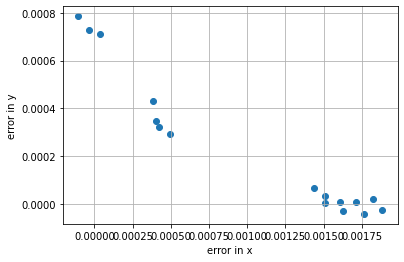

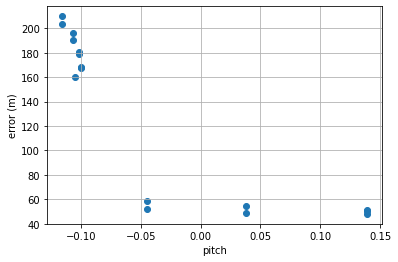

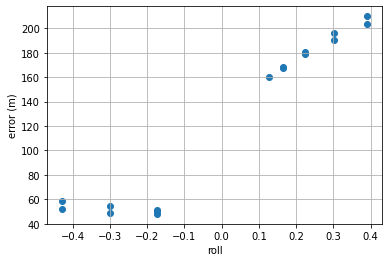

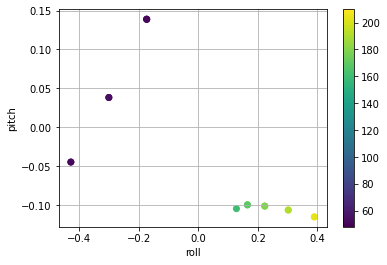

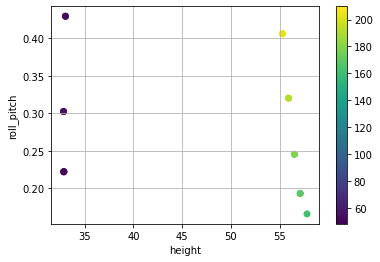

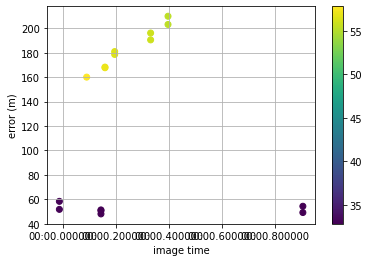

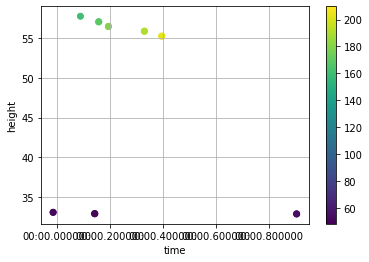

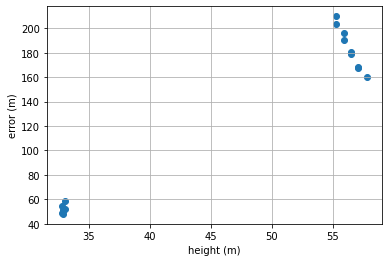

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np

print(sum(error_x)/len(error_x))
print(sum(error_y)/len(error_y))

total_error=[]
for i in range(len(error_x)):
    total_error.append(math.sqrt(error_x[i]**2+error_y[i]**2))

plt.figure(0)
plt.scatter(error_x,error_y)
plt.grid()
plt.xlabel("error in x")
plt.ylabel("error in y")

plt.figure(1)
plt.scatter(image_pitch,dist_error)
plt.grid()
plt.xlabel("pitch")
plt.ylabel("error (m)")

plt.figure(2)
plt.scatter(image_roll,dist_error)
plt.grid()
plt.xlabel("roll")
plt.ylabel("error (m)")


plt.figure(3)
plt.scatter(image_roll, image_pitch, c=dist_error, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel("roll")
plt.ylabel("pitch")

roll_pitch=[]
for i in range(len(error_x)):
    roll_pitch.append(math.sqrt(image_pitch[i]**2+image_roll[i]**2))

plt.figure(4)
plt.scatter(image_height,roll_pitch,c=dist_error, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel("height")
plt.ylabel("roll_pitch")

plt.figure(5)
plt.scatter(image_time,dist_error,c=image_height, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel("image time")
plt.ylabel("error (m)")

plt.figure(6)
plt.scatter(image_time,image_height,c=dist_error, cmap='viridis')
plt.grid()
plt.colorbar()
plt.xlabel("time")
plt.ylabel("height")

plt.figure(7)
plt.scatter(image_height, dist_error)
plt.xlabel("height (m)")
plt.ylabel("error (m)")
plt.grid()


In [38]:
plt.figure(8)
import pandas as pd
import seaborn as sns
df = pd.DataFrame.from_dict(np.array([image_pitch,image_roll,dist_error]).T)
df.columns = ['x','y','z']
df['z'] = pd.to_numeric(df['z'])
pivotted= df.pivot('y','x','z')

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.set_xlabel('image_pitch')
ax.set_ylabel('image_roll')
ax.set_zlabel('dist_error')
plt.grid()
#ax.plot_wireframe(cParams, gammas, avg_errors_array)
#ax.plot3D(cParams, gammas, avg_errors_array)
#ax.scatter3D(cParams, gammas, avg_errors_array, zdir='z',cmap='viridis')

surf = ax.plot_trisurf(df.x, df.y, df.z, cmap='viridis', linewidth=0.1)
ax.view_init(azim=0, elev=90)
fig.colorbar(surf, shrink=0.5, aspect=10)    
plt.show()


In [ ]:
class RLS:
    def __init__(self, num_vars, lam, delta):
        '''
        num_vars: number of variables including constant
        lam: forgetting factor, usually very close to 1.
        '''
        self.num_vars = num_vars
        
        # delta controls the initial state.
        self.A = delta*np.matrix(np.identity(self.num_vars))
        self.w = np.matrix(np.zeros(self.num_vars))
        self.w = self.w.reshape(self.w.shape[1],1)
        
        # Variables needed for add_obs
        self.lam_inv = lam**(-1)
        self.sqrt_lam_inv = math.sqrt(self.lam_inv)
        
        # A priori error
        self.a_priori_error = 0
        
        # Count of number of observations added
        self.num_obs = 0

    def add_obs(self, x, t):
        '''
        Add the observation x with label t.
        x is a column vector as a numpy matrix
        t is a real scalar
        '''            
        z = self.lam_inv*self.A*x
        alpha = float((1 + x.T*z)**(-1))
        self.a_priori_error = float(t - self.w.T*x)
        self.w = self.w + (t-alpha*float(x.T*(self.w+t*z)))*z
        self.A -= alpha*z*z.T
        self.num_obs += 1
        
    def fit(self, X, y):
        '''
        Fit a model to X,y.
        X and y are numpy arrays.
        Individual observations in X should have a prepended 1 for constant coefficient.
        '''
        for i in range(len(X)):
            x = np.transpose(np.matrix(X[i]))
            self.add_obs(x,y[i])


    def get_error(self):
        '''
        Finds the a priori (instantaneous) error. 
        Does not calculate the cumulative effect
        of round-off errors.
        '''
        return self.a_priori_error
    
    def predict(self, x):
        '''
        Predict the value of observation x. x should be a numpy matrix (col vector)
        '''
        return float(self.w.T*x)

In [66]:
import numpy as np
import matplotlib.pylab as plt
import padasip as pa

# creation of data
dfx = df[["lat", "lon", "px", "py", "alt", "roll", "pitch", "heading"]]
dfy = df[["est_lat2", "est_lon2"]]
x = dfx.to_numpy()
y = dfy.to_numpy()

LS = RLS(8,0.99,1)
# Not using the RLS.fit function because I want to remember all the predicted values
pred_x = []
pred_y = []
for i in range(20):
    LS.add_obs(np.matrix(x[i]),y[i])
print(LS.w)
# plot the predicted values against the non-noisy output
ax = plt.plot(pred_x, y-pred_y)
plt.show()

ValueError: shapes (8,8) and (1,8) not aligned: 8 (dim 1) != 1 (dim 0)

[[-4.94322404]
 [-3.80064484]
 [ 0.20000058]]


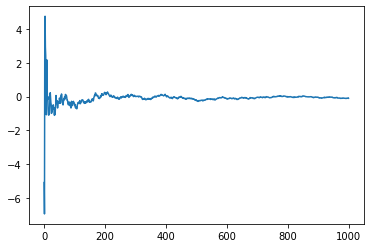

In [59]:
test_size = 1000
# Test function
f = lambda x: 0.2*x**2-3.8*x-5.1
# Gaussian noise to be added to the quadratic signal
noise = np.random.randn(test_size)
# You can play around with other noise (like sinusoidal)
#noise = [np.sin(2*np.pi*i/13) for i in range(test_size)]
y = np.array([f(i) for i in range(test_size)])
noisy_y = y + noise
lam = 0.98
LS = RLS(3,lam,1)
# Not using the RLS.fit function because I want to remember all the predicted values
pred_x = []
pred_y = []
for i in range(test_size):
    x = np.matrix(np.zeros((1,3)))
    x[0,0] = 1
    x[0,1] = i
    x[0,2] = i**2
    pred_x.append(i)
    pred_y.append(float(x*LS.w))
    LS.add_obs(x.T,noisy_y[i])
print(LS.w)
# plot the predicted values against the non-noisy output
ax = plt.plot(pred_x, y-pred_y)
plt.show()

In [65]:
x

matrix([[1.00000e+00, 9.99000e+02, 9.98001e+05]])

In [3]:
from ipyleaflet import (
    Map,
    Marker,
    MarkerCluster,
    TileLayer,
    ImageOverlay,
    Polyline,
    Polygon,
    Rectangle,
    Circle,
    CircleMarker,
    Popup,
    GeoJSON,
    DrawControl,
    basemaps,
    AwesomeIcon
)

from ipywidgets import HTML, Layout

center = [34.6252978589571, -77.34580993652344]
zoom = 100

m = Map(basemap=basemaps.Esri.WorldImagery, center=target_location, zoom=zoom, layout=Layout(width='800px', height='800px'))
m.add_layer(
    CircleMarker(location=target_location, radius=20)
)
m.add_layer(
    MarkerCluster(markers=[
        Marker(location=loc) for loc in locations
    ],
    disable_clustering_at_zoom=3)
)

avg = [sum(x)/len(x) for x in zip(*locations)]
icon = AwesomeIcon(marker_color="red")

m.add_layer(
    Marker(location=avg, color="red", icon=icon)
)

m

ModuleNotFoundError: No module named 'ipyleaflet'

Text(0, 0.5, 'pitch')

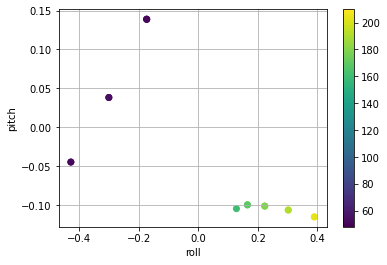

In [8]:
plt.figure(3)
plt.scatter(image_roll, image_pitch, c=dist_error, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel("roll")
plt.ylabel("pitch")

In [9]:
import pandas as pd
import numpy as np
df = [{ 
    "px":row[1][0][0][0], 
    "py": row[1][0][0][1], 
    "lat": row[1][1].lat,
    "lon": row[1][1].lon,
    "alt": row[1][1].alt,
    "roll": row[1][1].roll,
    "pitch": row[1][1].pitch,
    "heading": row[1][1].heading
} for row in enumerate(all_data)]
df.append({
    "px":1920/2, 
    "py": 1080/2, 
    "lat": target_location[0],
    "lon": target_location[1],
    "alt": 100,
    "roll": 0.4,
    "pitch": 0.4,
    "heading": 350
})
df = pd.DataFrame(df)


ModuleNotFoundError: No module named 'pandas'

In [7]:
import pyproj
import math
geodesic = pyproj.Geod(ellps='WGS84')
df["bearing_act"] = df.apply(lambda row: geodesic.inv(target_location[0], target_location[1], row.lat, row.lon)[0], axis=1)
df["distance_act"] = df.apply(lambda row: geodesic.inv(target_location[0], target_location[1], row.lat, row.lon)[2], axis=1)
df["anglez_act"] = df.apply(lambda row: math.degrees(math.atan(row.distance_act/row.alt)), axis=1)

RESOLUTION = np.array([1080, 1920]) # px
ASPECT_RATIO = RESOLUTION[1]/RESOLUTION[0]
SENSOR_W = 6.4 #mm
SENSOR_H = SENSOR_W / ASPECT_RATIO #mm
LENS_F = 6 #mm
FOV_X = 2 * math.atan2(SENSOR_W/2, LENS_F)
FOV_Y = 2 * math.atan2(SENSOR_H/2, LENS_F)
print(FOV_X, FOV_Y)

sin_rule = lambda alpha, a, b: math.asin(b * math.sin(alpha)/a)
# calculate angle of point in FOV
df["fov_angle_x"] = df.apply(lambda row: sin_rule((math.pi/2 - FOV_X)/2, 915.1, row.px) - FOV_X/2, axis=1)
df["fov_angle_y"] = df.apply(lambda row: sin_rule((math.pi/2 - FOV_Y)/2, 578.90595, row.py) - FOV_Y/2, axis=1)
# caculate the distance offset
df["offset_x"] = df.apply(lambda row: math.tan(row.fov_angle_x + row.roll) * row.alt, axis=1)
df["offset_y"] = df.apply(lambda row: math.tan(row.fov_angle_y + row.pitch) * row.alt, axis=1)
# rotate points to account for heading
df["Px"] = df.apply(lambda row: row.offset_x * math.cos(math.radians(-row.heading)) - row.offset_y * math.sin(math.radians(-row.heading)), axis=1)
df["Py"] = df.apply(lambda row: row.offset_x * math.sin(math.radians(-row.heading)) + row.offset_y * math.cos(math.radians(-row.heading)), axis=1)
# convert from meters to lat lon
df["est_lat"] = df.apply(lambda row: row.lat + row.Px/111320, axis=1)
df["est_lon"] = df.apply(lambda row: row.lon + row.Py/((40075000 * math.cos(math.radians(row.lat))) / 360), axis=1)

df["distance_error"] = df.apply(lambda row: geopy.distance.distance(target_location, (row.est_lat,row.est_lon)).m, axis=1)
df["bearing_est"] = df.apply(lambda row: geodesic.inv(row.est_lat, row.est_lon, row.lat, row.lon)[0], axis=1)
df["distance_est"] = df.apply(lambda row: geodesic.inv(row.est_lat, row.est_lon, row.lat, row.lon)[2], axis=1)
df["anglez_est"] = df.apply(lambda row: math.degrees(math.atan(row.distance_est/row.alt)), axis=1)

df["est_lat2"] = df.apply(lambda row: position_estimation.triangulate((row.px, row.py), LocationInfo(lat=row.lat, lon=row.lon, alt=row.alt, heading=row.heading, pitch=row.pitch, roll=row.roll))[0], axis=1)
df["est_lon2"] = df.apply(lambda row: position_estimation.triangulate((row.px, row.py), LocationInfo(lat=row.lat, lon=row.lon, alt=row.alt, heading=row.heading, pitch=row.pitch, roll=row.roll))[1], axis=1)

df["distance_error2"] = df.apply(lambda row: geopy.distance.distance(target_location, (row.est_lat2,row.est_lon2)).m, axis=1)
df["bearing_est2"] = df.apply(lambda row: geodesic.inv(row.est_lat2, row.est_lon2, row.lat, row.lon)[0], axis=1)
df["distance_est2"] = df.apply(lambda row: geodesic.inv(row.est_lat2, row.est_lon2, row.lat, row.lon)[2], axis=1)
df["anglez_est2"] = df.apply(lambda row: math.degrees(math.atan(row.distance_est2/row.alt)), axis=1)


ModuleNotFoundError: No module named 'pyproj'

In [6]:
coords = [(lat, lon) for lat,lon in zip(df.est_lat, df.est_lon)]

from ipyleaflet import (
    Map,
    Marker,
    MarkerCluster,
    TileLayer,
    ImageOverlay,
    Polyline,
    Polygon,
    Rectangle,
    Circle,
    CircleMarker,
    Popup,
    GeoJSON,
    DrawControl,
    basemaps,
    AwesomeIcon
)

from ipywidgets import HTML, Layout

center = [34.6252978589571, -77.34580993652344]
zoom = 100

m = Map(basemap=basemaps.Esri.WorldImagery, center=target_location, zoom=zoom, layout=Layout(width='800px', height='800px'))
m.add_layer(
    CircleMarker(location=target_location, radius=20)
)
m.add_layer(
    MarkerCluster(markers=[
        Marker(location=loc) for loc in coords
    ],
    disable_clustering_at_zoom=3)
)

avg = [sum(x)/len(x) for x in zip(*coords)]
icon = AwesomeIcon(marker_color="red")

m.add_layer(
    Marker(location=avg, color="red", icon=icon)
)

m

NameError: name 'df' is not defined

Text(0, 0.5, 'distance_est')

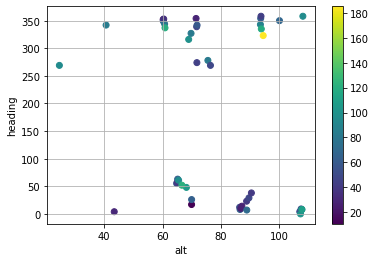

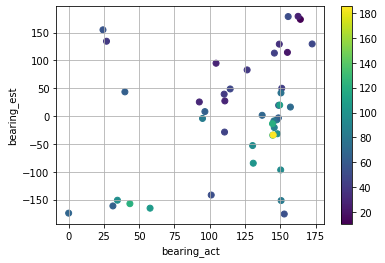

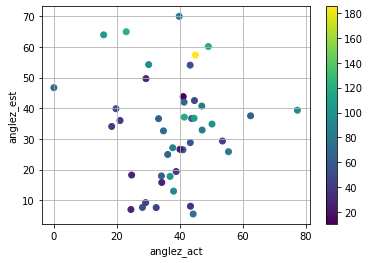

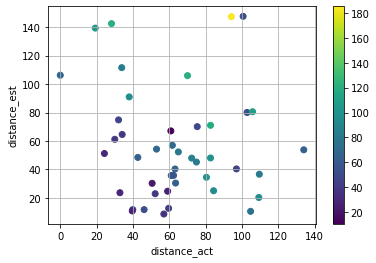

In [179]:
import matplotlib.pyplot as plt
plt.figure(10)
plt.scatter(df.alt, df.heading, c=df.distance_error, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel("alt")
plt.ylabel("heading")

plt.figure(11)
plt.scatter(df.bearing_act, df.bearing_est, c=df.distance_error, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel("bearing_act")
plt.ylabel("bearing_est")

plt.figure(12)
plt.scatter(df.anglez_act, df.anglez_est, c=df.distance_error, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel("anglez_act")
plt.ylabel("anglez_est")

plt.figure(13)
plt.scatter(df.distance_act, df.distance_est, c=df.distance_error, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel("distance_act")
plt.ylabel("distance_est")

Text(0, 0.5, 'pitch')

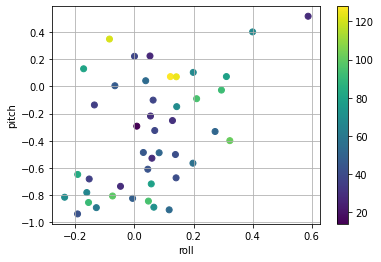

In [148]:
plt.figure(3)
plt.scatter(df.roll, df.pitch, c=df.distance_error, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel("roll")
plt.ylabel("pitch")

tried morphology, reduces noise but increases processing time by ~5%. doesn't seem to affect accuracy.
https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html

tried CLACHE - no noticeable accuracy increase

tried making C more negative - reduces noise and chance of identifying target

In [4]:
directory = r"C:\Users\olive\University of Surrey\UAS2 - General\2 Avionics\4 Testing\Image Rec\10_04_22\squares"
files = [f for f in os.listdir(directory)]


options = {
    "block_size": 399,
    "c": -39,
    "ksize": 39,
    "sigma": 0,
    "epsilon": 0.1,
    "square_ar": 0.2,
    "min_area": 1000,
    "sides":[4],
    "min_solidity": 0.6,
    "debug":True
}

results = 0
false_positives = []

for file in files:
    image = cv2.imread(directory + "//" + file)
    result = find_targets(image, options)
    try:
        result[0]
        results+=1
    except KeyboardInterrupt:
        raise Exception()
    except Exception:
        #find_targets(image, options)
        pass

print(results/len(files))
print(results)
print(len(files))


0.7666666666666667
23
30


In [ ]:
directory = r"C:\Users\olive\University of Surrey\UAS2 - General\2 Avionics\4 Testing\Image Rec\03_04_22\square"
image_number = 23
files = [f for f in os.listdir(directory)]
image = cv2.imread(directory + "//" + files[image_number])

options = {
    "block_size": 399,
    "c": -39,
    "ksize": 39,
    "sigma": 0,
    "epsilon": 0.1,
    "square_ar": 0.2,
    "min_area": 1000,
    "sides":[4],
    "debug":False
}

imgGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
display(imgGray)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(imgGray)
display(cl1)
imgBlurred = cv2.GaussianBlur(cl1, (59,59),0)
# laplacian = cv2.Laplacian(cv2.bitwise_not(imgBlurred),cv2.CV_64F)
# display(laplacian)
img_thresh = cv2.adaptiveThreshold(
    imgBlurred,
    255,
    cv2.ADAPTIVE_THRESH_MEAN_C, 
    cv2.THRESH_BINARY,
    399,
    -69
)
display(img_thresh)

contours, hierarchy = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
squareIndexes = filterContours(contours, options)

for index in squareIndexes:
    cv2.drawContours(image, contours[index], -1, (0, 255, 0), 3)
display(image)

In [4]:
import numpy as np

src = image
width  = src.shape[1]
height = src.shape[0]

# https://stackoverflow.com/questions/26602981/correct-barrel-distortion-in-opencv-manually-without-chessboard-image

distCoeff = np.zeros((4,1),np.float64)

distCoeff[0,0] = -0.7e-5 # k1
distCoeff[1,0] = 0 # k2
distCoeff[2,0] = 0 # p1
distCoeff[3,0] = 0.0 # p2

# assume unit matrix for camera
cam = np.eye(3,dtype=np.float32)

cam[0,2] = width/2.0  # define center x 
cam[1,2] = height/2.0 # define center y
cam[0,0] = 10        # define focal length x
cam[1,1] = 6        # define focal length y


image = cv2.imread(directory + "//" + files[3])

dst = cv2.undistort(image,cam,distCoeff)

numpy_vertical = np.vstack((image, dst))

width  = dst.shape[1]
height = dst.shape[0]
print(width, height)

display(numpy_vertical)

1920 1080


In [1]:
import numpy as np
import cv2 as cv
from theia.image_segmentation import find_targets

directory = r"C:\Users\pm\Downloads\images 2"
files = [f for f in os.listdir(directory)]

for image_number in range(0,len(files)):
    image = cv.imread(directory + "/" + files[image_number])

    options = {
            "block_size": 399,
            "c": -39,
            "ksize": 39,
            "sigma": 0,
            "epsilon": 0.1,
            "min_area": 1000,
            "sides":[4],
            "min_solidity": 0.6,
            "debug": True
    }
    print(find_targets(image,options))




[]
[]
[]
[]
[]
[]
[]
[]
[]
[(52, 741)]
[]
[]
[]
[]
[(348, 354)]
[(343, 123)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(1038, 91)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(39, 777)]
[(356, 1018), (164, 641)]
[(410, 913)]
[(346, 994)]
[(1089, 974)]
[(39, 1057), (553, 991), (1154, 860)]
[(93, 1038), (617, 919), (1210, 765)]
[(152, 1008), (672, 853), (1019, 598)]
[(54, 694), (677, 387), (162, 205)]
[(1419, 439), (621, 255), (120, 93)]
[(557, 90), (539, 20)]
[(528, 819), (36, 374), (720, 283), (258, 237), (500, 39)]
[(503, 649), (27, 204), (706, 116), (247, 63)]
[(509, 533), (163, 243)]
[(490, 432), (152, 141)]
[(107, 785), (463, 366), (137, 75)]
[(30, 629), (372, 317)]
[(310, 264)]
[]
[]
[]
[]
[]
[]
[]
[]